In [24]:
import pandas as pd
import warnings
import datetime
from collections import Counter
warnings.filterwarnings('ignore')
import sys
sys.path.append(r'C:\Users\keke\Desktop\量化\代码\策略设计\calculate_indicator')
from calculate_indicator.trend_indicator import *
from calculate_indicator.reversal_indicator import *

In [25]:
index_list = ['BBI','VIDYA','RSIH','WMA','T3']

data_path = r"C:\Users\keke\Desktop\量化\代码\中债指数数据\7-10年.csv"
df = pd.read_csv(data_path)


df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.set_index('date', inplace=True)

df.index = df.index.strftime('%Y-%m-%d')

df = df["2010-01-04":"2024-02-01"]

print(df)

               close
date                
2010-01-04  117.1775
2010-01-05  117.1958
2010-01-06  117.1626
2010-01-07  116.9986
2010-01-08  116.8875
...              ...
2024-01-26  124.8652
2024-01-29  124.8822
2024-01-30  125.2514
2024-01-31  125.4937
2024-02-01  125.4937

[3524 rows x 1 columns]


In [27]:
df = BBI_df(df)
df = VIDYA_df(df)
df = RSIH_df(df)
df = WMA_df(df)
df = T3_df(df)


signal_long = pd.DataFrame(index = df.index)
signal_long['BBI'] = df["BBI_signal"]

signal_long['VIDYA'] = df["VIDYA_signal"]
signal_long['RSIH'] = df["RSIH_signal"]
signal_long['WMA'] = df["WMA_signal"]
signal_long['T3'] = df["T3_signal"]

signal_long['long_count'] = signal_long.apply(lambda x: Counter(x)[1], axis=1)
signal_long['signal'] = signal_long.apply(lambda x: 1 if x['long_count'] > len(index_list) / 2 else -1,axis=1)

print(signal_long)


            BBI  VIDYA  RSIH  WMA   T3  long_count  signal
date                                                      
2010-01-04  0.0    0.0   0.0  0.0  0.0           0      -1
2010-01-05  0.0    0.0   0.0  0.0  0.0           0      -1
2010-01-06  0.0    0.0  -1.0  0.0 -1.0           0      -1
2010-01-07  0.0    0.0  -1.0  0.0 -1.0           0      -1
2010-01-08  0.0    0.0  -1.0  0.0 -1.0           0      -1
...         ...    ...   ...  ...  ...         ...     ...
2024-01-26  1.0    1.0   1.0  1.0  1.0           5       1
2024-01-29  1.0    1.0   1.0  1.0  1.0           5       1
2024-01-30  1.0    1.0   1.0  1.0  1.0           5       1
2024-01-31  1.0    1.0   1.0  1.0  1.0           5       1
2024-02-01  1.0    1.0   1.0  1.0  1.0           5       1

[3524 rows x 7 columns]


In [28]:
# daily_return表示价格本身波动，pct_change()表示计算每日价格的变化率
signal_long['daily_return'] = df['close'].pct_change()
# strategy_return表示策略的收益，因为n - 1天算出来的signal用于n天的交易，所以要shift(1)
# 如果daily_return为正，signal为1，策略收益为正，signal为-1，策略收益为负，反之亦然
signal_long['strategy_return'] = signal_long['signal'].shift(1) * signal_long['daily_return']
# cumpord()计算累计收益，将策略收益累加并相乘
signal_long['cumulative_return'] = (1 + signal_long['strategy_return']).cumprod()

print(signal_long)

            BBI  VIDYA  RSIH  WMA   T3  long_count  signal  daily_return  \
date                                                                       
2010-01-04  0.0    0.0   0.0  0.0  0.0           0      -1           NaN   
2010-01-05  0.0    0.0   0.0  0.0  0.0           0      -1      0.000156   
2010-01-06  0.0    0.0  -1.0  0.0 -1.0           0      -1     -0.000283   
2010-01-07  0.0    0.0  -1.0  0.0 -1.0           0      -1     -0.001400   
2010-01-08  0.0    0.0  -1.0  0.0 -1.0           0      -1     -0.000950   
...         ...    ...   ...  ...  ...         ...     ...           ...   
2024-01-26  1.0    1.0   1.0  1.0  1.0           5       1      0.000277   
2024-01-29  1.0    1.0   1.0  1.0  1.0           5       1      0.000136   
2024-01-30  1.0    1.0   1.0  1.0  1.0           5       1      0.002956   
2024-01-31  1.0    1.0   1.0  1.0  1.0           5       1      0.001935   
2024-02-01  1.0    1.0   1.0  1.0  1.0           5       1      0.000000   

           

In [29]:
# 策略总体评价


# 年化收益率，一年交易日为252天
annual_return = (signal_long['cumulative_return'].iloc[-1]) ** (252 / len(signal_long)) - 1

# 波动率（年化）
annual_volatility = signal_long['strategy_return'].std() * np.sqrt(252)

# 收益波动比（夏普比率）
sharpe_ratio = annual_return / annual_volatility

# 最大回撤，cummax()计算当前位置和之前位置的最大值
cumulative_return = (1 + signal_long['strategy_return']).cumprod()
drawdown = cumulative_return.div(cumulative_return.cummax()) - 1
max_drawdown = drawdown.min()

# 择时胜率
winning_days = len(signal_long[signal_long['strategy_return'] > 0])
total_days = len(signal_long[~signal_long['strategy_return'].isnull()])
winning_rate = winning_days / total_days

# 平均盈亏比
average_win = signal_long[signal_long['strategy_return'] > 0]['strategy_return'].mean()
average_loss = signal_long[signal_long['strategy_return'] < 0]['strategy_return'].mean()
average_win_loss_ratio = average_win / abs(average_loss)

print(f"策略累计收益率: {signal_long['cumulative_return'].iloc[-1] - 1}")
print(f"年化收益率: {annual_return}")
print(f"波动率: {annual_volatility}")
print(f"收益波动比（夏普比率）: {sharpe_ratio}")
print(f"最大回撤: {max_drawdown}")
print(f"择时胜率: {winning_rate}")
print(f"平均盈亏比: {average_win_loss_ratio}")

策略累计收益率: 1.2513033412183256
年化收益率: 0.059747577467624824
波动率: 0.025264734868613713
收益波动比（夏普比率）: 2.3648606557058716
最大回撤: -0.030908724938915277
择时胜率: 0.5415838773772353
平均盈亏比: 1.3187911344088106


In [30]:
#每年表现刻画

signal_long.index = pd.to_datetime(signal_long.index)


signal_long['year'] = signal_long.index.year


signal_long['year'] = signal_long.index.year
grouped = signal_long.groupby('year')


annual_performance = pd.DataFrame()


for name, group in grouped:
    annual_return = (1 + group['strategy_return']).prod() - 1
    annual_volatility = group['strategy_return'].std() * np.sqrt(len(group))
    sharpe_ratio = annual_return / annual_volatility
    
    cumulative_return = (1 + group['strategy_return']).cumprod()
    drawdown = cumulative_return.div(cumulative_return.cummax()) - 1
    max_drawdown = drawdown.min()
    
    winning_days = len(group[group['strategy_return'] > 0])
    total_days = len(group[~group['strategy_return'].isnull()])
    winning_rate = winning_days / total_days if total_days != 0 else 0
    
    average_win = group[group['strategy_return'] > 0]['strategy_return'].mean()
    average_loss = group[group['strategy_return'] < 0]['strategy_return'].mean()
    average_win_loss_ratio = average_win / abs(average_loss) if average_loss != 0 else 0
    
    annual_performance.loc[name, 'Annual Return'] = annual_return
    annual_performance.loc[name, 'Annual Volatility'] = annual_volatility
    annual_performance.loc[name, 'Sharpe Ratio'] = sharpe_ratio
    annual_performance.loc[name, 'Max Drawdown'] = max_drawdown
    annual_performance.loc[name, 'Winning Rate'] = winning_rate
    annual_performance.loc[name, 'Average Win/Loss Ratio'] = average_win_loss_ratio

print(annual_performance)

      Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  \
2010       0.082181           0.032927      2.495871     -0.010459   
2011       0.072159           0.027879      2.588285     -0.015263   
2012       0.046086           0.015724      2.930878     -0.009919   
2013       0.091110           0.028896      3.153047     -0.011275   
2014       0.071449           0.033370      2.141138     -0.030909   
2015       0.100508           0.029864      3.365518     -0.009446   
2016       0.057736           0.024260      2.379879     -0.015033   
2017       0.053651           0.024830      2.160760     -0.010210   
2018       0.058278           0.023383      2.492257     -0.013549   
2019       0.052878           0.019979      2.646669     -0.006432   
2020       0.055953           0.031669      1.766786     -0.013035   
2021       0.025413           0.018751      1.355335     -0.014253   
2022       0.037214           0.018177      2.047279     -0.007363   
2023       0.024784 

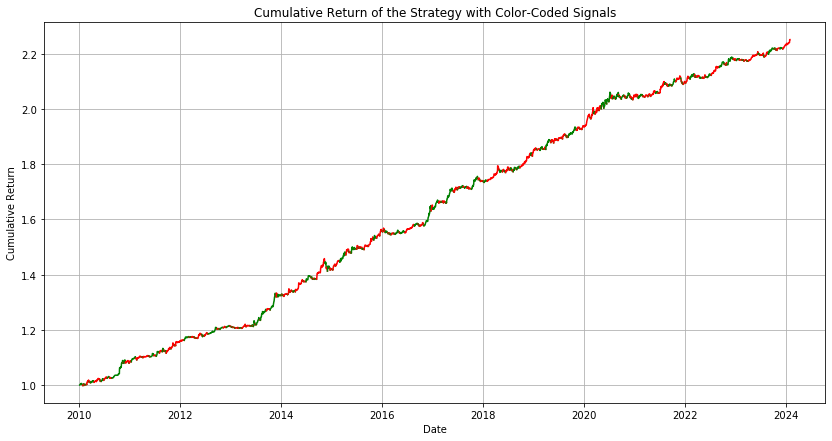

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))


change_points = signal_long[signal_long['signal'] != signal_long['signal'].shift(1)].index

start_idx = signal_long.index[0]

# 做多的时间为r，做空的时间为g
for end_idx in change_points:
    color = 'r' if signal_long.loc[start_idx, 'signal'] == 1 else 'g'
    plt.plot(signal_long.loc[start_idx:end_idx, 'cumulative_return'], color=color)
    start_idx = end_idx


color = 'r' if signal_long.loc[start_idx, 'signal'] == 1 else 'g'
plt.plot(signal_long.loc[start_idx:, 'cumulative_return'], color=color)


plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of the Strategy with Color-Coded Signals')


plt.grid(True)

plt.show()

In [32]:
# background_gradeient设置渐变色，lime表示亮绿色
styled_annual_performance = annual_performance.style.format({
    'Annual Return': "{:.2%}",
    'Annual Volatility': "{:.2%}",
    'Sharpe Ratio': "{:.2f}",
    'Max Drawdown': "{:.2%}",
    'Winning Rate': "{:.2%}",
    'Average Win/Loss Ratio': "{:.2f}"
}).background_gradient(subset=['Annual Return', 'Sharpe Ratio', 'Winning Rate'], cmap='Greens')\
.background_gradient(subset=['Annual Volatility', 'Max Drawdown'], cmap='Reds_r')\
.highlight_max(subset=['Annual Return', 'Sharpe Ratio', 'Winning Rate'], color='lime')\
.highlight_min(subset=['Annual Volatility', 'Max Drawdown'], color='red')


styled_annual_performance

,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown,Winning Rate,Average Win/Loss Ratio
2010,8.22%,3.29%,2.50,-1.05%,57.03%,1.24
2011,7.22%,2.79%,2.59,-1.53%,50.40%,1.60
2012,4.61%,1.57%,2.93,-0.99%,57.43%,1.26
2013,9.11%,2.89%,3.15,-1.13%,56.40%,1.42
2014,7.14%,3.34%,2.14,-3.09%,54.00%,1.29
2015,10.05%,2.99%,3.37,-0.94%,54.62%,1.49
2016,5.77%,2.43%,2.38,-1.50%,54.18%,1.32
2017,5.37%,2.48%,2.16,-1.02%,51.39%,1.37
2018,5.83%,2.34%,2.49,-1.35%,55.95%,1.23
2019,5.29%,2.00%,2.65,-0.64%,54.40%,1.33


In [22]:
#考虑只能做多
signal_long['signal'] = signal_long['signal'].replace(-1, 0)


signal_long['strategy_return'] = signal_long['signal'].shift(1) * signal_long['daily_return']

signal_long['cumulative_return'] = (1 + signal_long['strategy_return']).cumprod()


signal_long['year'] = signal_long.index.year
grouped = signal_long.groupby('year')

annual_performance = pd.DataFrame()

for name, group in grouped:
    annual_return = (1 + group['strategy_return']).prod() - 1
    annual_volatility = group['strategy_return'].std() * np.sqrt(len(group))
    sharpe_ratio = annual_return / annual_volatility
    
    cumulative_return = (1 + group['strategy_return']).cumprod()
    drawdown = cumulative_return.div(cumulative_return.cummax()) - 1
    max_drawdown = drawdown.min()
    
    winning_days = len(group[group['strategy_return'] > 0])
    total_days = len(group[~group['strategy_return'].isnull()])
    lose_days=len(group[group['strategy_return'] < 0])
    winning_rate = winning_days / (lose_days+winning_days) 
    
    average_win = group[group['strategy_return'] > 0]['strategy_return'].mean()
    average_loss = group[group['strategy_return'] < 0]['strategy_return'].mean()
    average_win_loss_ratio = average_win / abs(average_loss) if average_loss != 0 else 0
    
    annual_performance.loc[name, 'Annual Return'] = annual_return
    annual_performance.loc[name, 'Annual Volatility'] = annual_volatility
    annual_performance.loc[name, 'Sharpe Ratio'] = sharpe_ratio
    annual_performance.loc[name, 'Max Drawdown'] = max_drawdown
    annual_performance.loc[name, 'Winning Rate'] = winning_rate
    annual_performance.loc[name, 'Average Win/Loss Ratio'] = average_win_loss_ratio

print(annual_performance)

      Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  \
2010       0.029043           0.018595      1.561912     -0.007760   
2011       0.054201           0.020792      2.606785     -0.007527   
2012       0.018241           0.011170      1.633045     -0.006574   
2013       0.004863           0.014056      0.345981     -0.010149   
2014       0.072704           0.026203      2.774606     -0.019959   
2015       0.075837           0.022236      3.410546     -0.006774   
2016       0.020018           0.013890      1.441187     -0.013136   
2017      -0.007753           0.014138     -0.548336     -0.009277   
2018       0.055736           0.020090      2.774318     -0.010591   
2019       0.031163           0.014548      2.142169     -0.004311   
2020       0.023315           0.023420      0.995503     -0.023872   
2021       0.025872           0.015306      1.690326     -0.008178   
2022       0.018398           0.012270      1.499391     -0.006278   
2023       0.022544 

In [23]:
styled_annual_performance = annual_performance.style.format({
    'Annual Return': "{:.2%}",
    'Annual Volatility': "{:.2%}",
    'Sharpe Ratio': "{:.2f}",
    'Max Drawdown': "{:.2%}",
    'Winning Rate': "{:.2%}",
    'Average Win/Loss Ratio': "{:.2f}"
}).background_gradient(subset=['Annual Return', 'Sharpe Ratio', 'Winning Rate'], cmap='Greens')\
.background_gradient(subset=['Annual Volatility', 'Max Drawdown'], cmap='Reds_r')\
.highlight_max(subset=['Annual Return', 'Sharpe Ratio', 'Winning Rate'], color='lime')\
.highlight_min(subset=['Annual Volatility', 'Max Drawdown'], color='red')


styled_annual_performance

,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown,Winning Rate,Average Win/Loss Ratio
2010,2.90%,1.86%,1.56,-0.78%,57.39%,1.11
2011,5.42%,2.08%,2.61,-0.75%,50.30%,1.83
2012,1.82%,1.12%,1.63,-0.66%,54.05%,1.33
2013,0.49%,1.41%,0.35,-1.01%,46.88%,1.28
2014,7.27%,2.62%,2.77,-2.00%,52.47%,1.74
2015,7.58%,2.22%,3.41,-0.68%,58.00%,1.56
2016,2.00%,1.39%,1.44,-1.31%,56.64%,1.13
2017,-0.78%,1.41%,-0.55,-0.93%,45.63%,1.02
2018,5.57%,2.01%,2.77,-1.06%,60.12%,1.28
2019,3.12%,1.45%,2.14,-0.43%,54.42%,1.40
